# JamUNet model trained with the spatial dataset

This notebook was used for training the model.

In [1]:
# move to root directory

%cd ..

c:\Users\anton\OneDrive\Desktop\jamuna_morpho


In [ ]:
# reload modules to avoid restarting the notebook every time these are updated

%load_ext autoreload
%autoreload 2

In [ ]:
# import modules 

import torch
import joblib
import copy

from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

from model.train_eval import * 
from preprocessing.dataset_generation import create_full_dataset
from preprocessing.data_normalization import *
from postprocessing.save_results import *
from postprocessing.plot_results import *

# enable interactive widgets in Jupyter Notebook
%matplotlib inline
%matplotlib widget

In [ ]:
# set the device where operations are performed
# if only one GPU is present you might need to remove the index "0" 
# torch.device('cuda:0') --> torch.device('cuda') / torch.cuda.get_device_name(0) --> torch.cuda.get_device_name() 

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("CUDA Device Count: ", torch.cuda.device_count())
    print("CUDA Device Name: ", torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    
print(f'Using device: {device}')

CUDA Device Count:  1
CUDA Device Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda:0


In [ ]:
# set common keys required for functions

train = 'training'
val = 'validation'
test = 'testing'

In [ ]:
# load all datasets

# by default March images are used - if another month is used change the number (available months: 1-4)
dataset_path = r'data\satellite\dataset_month3' 

dtype=torch.float32

train_set = create_full_dataset(train, dir_folders=dataset_path, device=device, dtype=dtype)
val_set = create_full_dataset(val, dir_folders=dataset_path, device=device, dtype=dtype)
test_set = create_full_dataset(test, dir_folders=dataset_path, device=device, dtype=dtype)

c:\ProgramData\Anaconda3\envs\braided\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [7]:
print(f'Training dataset samples: {len(train_set)},\n\
Validation dataset samples: {len(val_set)},\n\
Testing dataset samples: {len(test_set)}')

Training dataset samples: 518,
Validation dataset samples: 19,
Testing dataset samples: 19


**<span style="color:red">Attention!</span>** 
\
Uncomment the next cells if larger training, validation, and testing datasets are needed. These cells load all months datasets (January, February, March, and April) and then merge them into one dataset. 
\
Keep in mind that due to memory constraints, it is likely that not all four datasets can be loaded. 
\
Make sure to load the training, validation, and testing datasets in different cells to reduce memory issues.

In [7]:
# dataset_jan = r'data\satellite\dataset_month1'
# dataset_feb = r'data\satellite\dataset_month2'
# dataset_mar = r'data\satellite\dataset_month3'
# dataset_apr = r'data\satellite\dataset_month4'

# dtype=torch.float32

In [ ]:
# inputs_train_jan, targets_train_jan = create_full_dataset(train, dir_folders=dataset_jan, device=device, dtype=dtype).tensors
# inputs_train_feb, targets_train_feb = create_full_dataset(train, dir_folders=dataset_feb, device=device, dtype=dtype).tensors
# inputs_train_mar, targets_train_mar = create_full_dataset(train, dir_folders=dataset_mar, device=device, dtype=dtype).tensors
# inputs_train_apr, targets_train_apr = create_full_dataset(train, dir_folders=dataset_apr, device=device, dtype=dtype).tensors

# inputs_train = torch.cat((inputs_train_jan, inputs_train_feb, inputs_train_mar, inputs_train_apr))
# targets_train = torch.cat((targets_train_jan, targets_train_feb, targets_train_mar, targets_train_apr))
# train_set = TensorDataset(inputs_train, targets_train)

In [9]:
# inputs_val_jan, targets_val_jan = create_full_dataset(val, dir_folders=dataset_jan, device=device, dtype=dtype).tensors
# inputs_val_feb, targets_val_feb = create_full_dataset(val, dir_folders=dataset_feb, device=device, dtype=dtype).tensors
# inputs_val_mar, targets_val_mar = create_full_dataset(val, dir_folders=dataset_mar, device=device, dtype=dtype).tensors
# inputs_val_apr, targets_val_apr = create_full_dataset(val, dir_folders=dataset_apr, device=device, dtype=dtype).tensors

# inputs_val = torch.cat((inputs_val_jan, inputs_val_feb, inputs_val_mar, inputs_val_apr))
# targets_val = torch.cat((targets_val_jan, targets_val_feb, targets_val_mar, targets_val_apr))
# val_set = TensorDataset(inputs_val, targets_val)

In [10]:
# inputs_test_jan, targets_test_jan = create_full_dataset(test, dir_folders=dataset_jan, device=device, dtype=dtype).tensors
# inputs_test_feb, targets_test_feb = create_full_dataset(test, dir_folders=dataset_feb, device=device, dtype=dtype).tensors
# inputs_test_mar, targets_test_mar = create_full_dataset(test, dir_folders=dataset_mar, device=device, dtype=dtype).tensors
# inputs_test_apr, targets_test_apr = create_full_dataset(test, dir_folders=dataset_apr, device=device, dtype=dtype).tensors

# inputs_test = torch.cat((inputs_test_jan, inputs_test_feb, inputs_test_mar, inputs_test_apr))
# targets_test = torch.cat((targets_test_jan, targets_test_feb, targets_test_mar, targets_test_apr))
# test_set = TensorDataset(inputs_test, targets_test)

**<span style="color:red">Attention!</span>** 
\
It is not needed to scale and normalize the dataset as the pixel values are already $[0, 1]$.**
\
If scaling and normalization are performed anyways, then **the model inputs have to be changed** as the normalized datasets are used.

In [ ]:
# normalize inputs and targets using the training dataset

# scaler_x, scaler_y = scaler(train_set)

# normalized_train_set = normalize_dataset(train_set, scaler_x, scaler_y)
# normalized_val_set = normalize_dataset(val_set, scaler_x, scaler_y)
# normalized_test_set = normalize_dataset(test_set, scaler_x, scaler_y)

In [ ]:
# save scalers to be loaded in seperate notebooks (i.e., for testing the model)
# should not change unless seed is changed or augmentation increased (randomsplit changes)

# joblib.dump(scaler_x, r'model\scalers\scaler_x.joblib')
# joblib.dump(scaler_y, r'model\scalers\scaler_y.joblib')

In [ ]:
# load JamUNet architecture

from model.CNN_UNet.st_unet.st_unet import *

n_channels = train_set[0][0].shape[0]
n_classes = 1
init_hid_dim = 8
kernel_size = 3
pooling = 'max'

model = UNet3D(n_channels=n_channels, n_classes=n_classes, init_hid_dim=init_hid_dim, 
               kernel_size=kernel_size, pooling=pooling, bilinear=False, drop_channels=False)

In [ ]:
# print model architecture

model

BayesianUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3d): Conv3d(8, 8, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
  )
  (down1): Down(
    (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv3d): Conv3d(16, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
  

In [ ]:
# print total number of parameters and model size

num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters:.2e}")
model_size_MB = num_parameters * 4 / (1024 ** 2)  # assuming float32 precision
print(f"Model size: {model_size_MB:.2f} MB")

Number of parameters: 5.23e+05
Model size: 1.99 MB


**<span style="color:red">Attention!</span>** 
\
Since it is not needed to scale and normalize the dataset (see above), the input for the Data Loader are not the normalized datasets.
\
If normalization is performed, the normalized datasets become the inputs to the model.

In [ ]:
# hyperparameters
learning_rate = 0.05
batch_size = 16
num_epochs = 100
water_threshold = 0.5
physics = False    # no physics-induced loss terms in the training loss if False
alpha_er = 1e-4    # needed only if physics=True
alpha_dep = 1e-4   # needed only if physics=True

# optimizer to train the model with backpropagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# scheduler for decreasing the learning rate 
# every tot epochs (step_size) with given factor (gamma)
step_size = 15     # set to None to remove the scheduler
gamma = 0.75       # set to None to remove the scheduler
if (step_size and gamma) is not None:
    scheduler = StepLR(optimizer, step_size = step_size, gamma = gamma)

# dataloaders to input data to the model in batches -- see note above if normalization is performed
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
# initialize training, validation losses and metrics
train_losses, val_losses = [], []
accuracies, precisions, recalls, f1_scores, csi_scores = [], [], [], [], []

# set classification loss - possible options: 'BCE', 'BCE_Logits', and 'Focal'
loss_f = 'BCE' 
# set regression loss for physics-induced terms
# possible options: 'Huber', 'RMSE', and 'MAE'
loss_er_dep = 'Huber'

for epoch in range(1, num_epochs+1):
    
    # update learning rate
    if (step_size and gamma) is not None:
        scheduler.step() # update the learning rate
    
    # model training
    train_loss = training_unet(model, train_loader, optimizer, water_threshold=water_threshold, 
                               device=device, loss_f=loss_f, physics=physics, alpha_er=alpha_er, 
                               alpha_dep=alpha_dep, loss_er_dep=loss_er_dep)

    # model validation
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_csi_score = validation_unet(model, val_loader, 
                                                                                                     device=device, loss_f=loss_f, 
                                                                                                     water_threshold=water_threshold)

    if epoch == 1:
        best_loss = val_loss
        best_recall = val_recall
    
    # save model with min val loss
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0
    # save model with max recall
    if val_recall>=best_recall:
        best_model_recall = copy.deepcopy(model)
        best_recall = val_recall
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    accuracies.append(val_accuracy)
    precisions.append(val_precision)
    recalls.append(val_recall)
    f1_scores.append(val_f1_score)
    csi_scores.append(val_csi_score)

    count += 1
    
    if epoch%1 == 0:
        print(f"Epoch: {epoch} | " +
              f"Training loss: {train_loss:.2e}, Validation loss: {val_loss:.2e}, Best validation loss: {best_loss:.2e} " + 
              f" | Metrics: Accuracy: {val_accuracy:.3f}, Precision: {val_precision:.3f}, Recall: {val_recall:.3f},\
 F1-score: {val_f1_score:.3f}, CSI-score: {val_csi_score:.3f}, Best recall: {best_recall:.3f}")
        if (step_size and gamma) is not None:
            print(f'Current learning rate: {scheduler.get_last_lr()[0]}')

Epoch: 1 | Training loss: 2.48e-01, Validation loss: 1.90e-01, Best validation loss: 1.90e-01  | Metrics: Accuracy: 0.921, Precision: 0.632, Recall: 0.595, F1-score: 0.613, CSI-score: 0.442, Best recall: 0.595
Current learning rate: 0.05
Epoch: 2 | Training loss: 1.80e-01, Validation loss: 1.63e-01, Best validation loss: 1.63e-01  | Metrics: Accuracy: 0.923, Precision: 0.630, Recall: 0.654, F1-score: 0.642, CSI-score: 0.473, Best recall: 0.654
Current learning rate: 0.05
Epoch: 3 | Training loss: 1.78e-01, Validation loss: 1.61e-01, Best validation loss: 1.61e-01  | Metrics: Accuracy: 0.925, Precision: 0.643, Recall: 0.644, F1-score: 0.644, CSI-score: 0.475, Best recall: 0.654
Current learning rate: 0.05
Epoch: 4 | Training loss: 1.75e-01, Validation loss: 1.57e-01, Best validation loss: 1.57e-01  | Metrics: Accuracy: 0.928, Precision: 0.654, Recall: 0.660, F1-score: 0.657, CSI-score: 0.489, Best recall: 0.660
Current learning rate: 0.05
Epoch: 5 | Training loss: 1.74e-01, Validation l

In [13]:
metrics = [accuracies, precisions, recalls, f1_scores, csi_scores]

In [ ]:
# store training and validation losses and metrics to be stored in a .csv file for later postprocessing
# always check the dataset month key

save_losses_metrics(train_losses, val_losses, metrics, 'spatial', model, 3, init_hid_dim, 
                    kernel_size, pooling, learning_rate, step_size, gamma, batch_size, num_epochs, 
                    water_threshold, physics, alpha_er, alpha_dep, dir_output=r'model\losses_metrics')

**<span style="color:red">Attention!</span>** 
\
Always remember to rename the <code>save_path</code> file before running the whole notebook to avoid overwrting it.

In [ ]:
# save model with min validation loss
# always check the dataset month key

save_model_path(best_model, 'spatial', 'loss', 3, init_hid_dim, kernel_size, pooling, learning_rate, 
                step_size, gamma, batch_size, num_epochs, water_threshold) 

model\models_trained\BayesianUNet_bloss_month3_4dwns_8ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_100epochs_0.5wthr.pth


In [ ]:
# save model with max recall
# always check the dataset month key

save_model_path(best_model_recall, 'spatial', 'recall', 3, init_hid_dim, kernel_size, pooling, learning_rate, 
                step_size, gamma, batch_size, num_epochs, water_threshold) 

model\models_trained\BayesianUNet_brecall_month3_4dwns_8ihiddim_3ker_maxpool_0.05ilr_15step_0.75gamma_16batch_100epochs_0.5wthr.pth


In [ ]:
# test the min loss model - average loss and metrics

model_loss = copy.deepcopy(best_model)
test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_csi_score = validation_unet(model_loss, test_loader, device=device, loss_f = loss_f)

print(f'Average metrics for test dataset using model with best validation loss:\n\n\
{loss_f} loss:          {test_loss:.3e}\n\
Accuracy:          {test_accuracy:.3f}\n\
Precision:         {test_precision:.3f}\n\
Recall:            {test_recall:.3f}\n\
F1 score:          {test_f1_score:.3f}\n\
CSI score:         {test_csi_score:.3f}')

Average metrics for test dataset using model with best validation loss:

BCE loss:          1.385e-01
Accuracy:          0.937
Precision:         0.727
Recall:            0.720
F1 score:          0.724
CSI score:         0.567


In [ ]:
# test the max recall model - average loss and metrics

model_recall = copy.deepcopy(best_model_recall)
test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_csi_score = validation_unet(model_recall, test_loader, device=device, loss_f = loss_f)

print(f'Average metrics for test dataset using model with best validation recall:\n\n\
{loss_f} loss:          {test_loss:.3e}\n\
Accuracy:          {test_accuracy:.3f}\n\
Precision:         {test_precision:.3f}\n\
Recall:            {test_recall:.3f}\n\
F1 score:          {test_f1_score:.3f}\n\
CSI score:         {test_csi_score:.3f}')

Average metrics for test dataset using model with best validation recall:

BCE loss:          1.530e-01
Accuracy:          0.932
Precision:         0.671
Recall:            0.791
F1 score:          0.726
CSI score:         0.571


ATTENTION: the argument `save_name` is not specified: the plot is not saved.


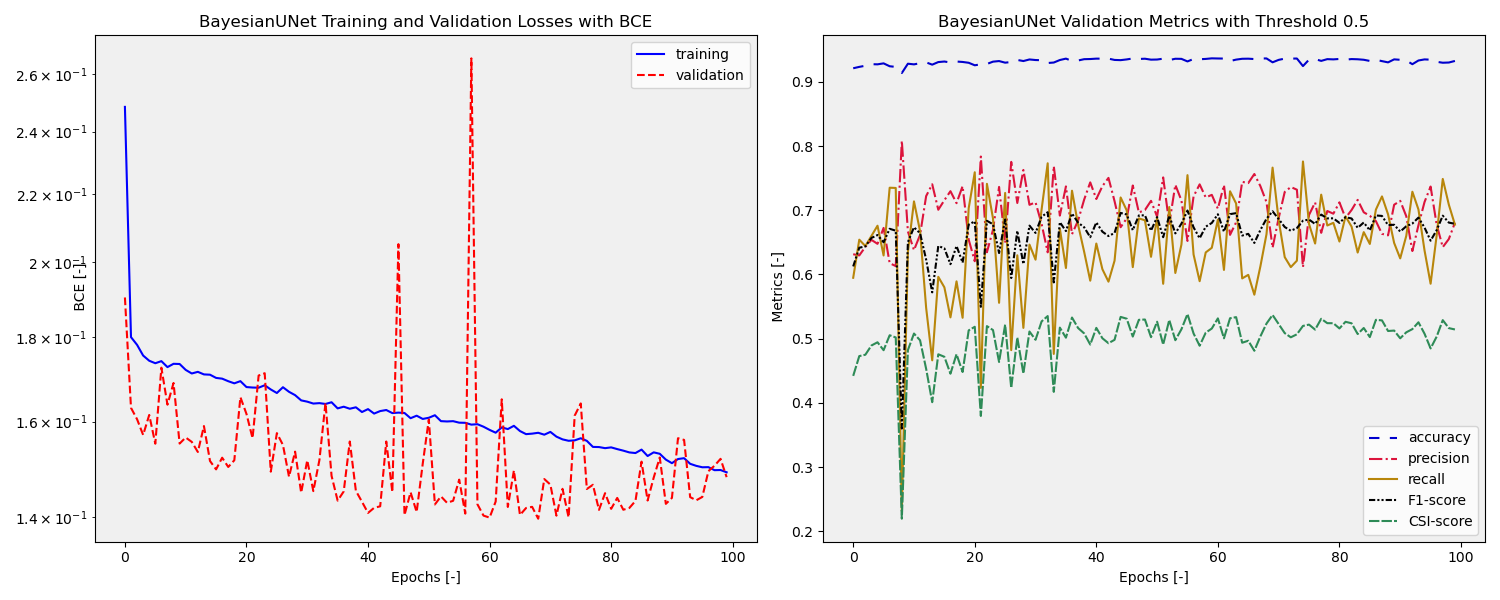

In [20]:
plot_losses_metrics(train_losses, val_losses, metrics, model_recall, loss_f=loss_f)

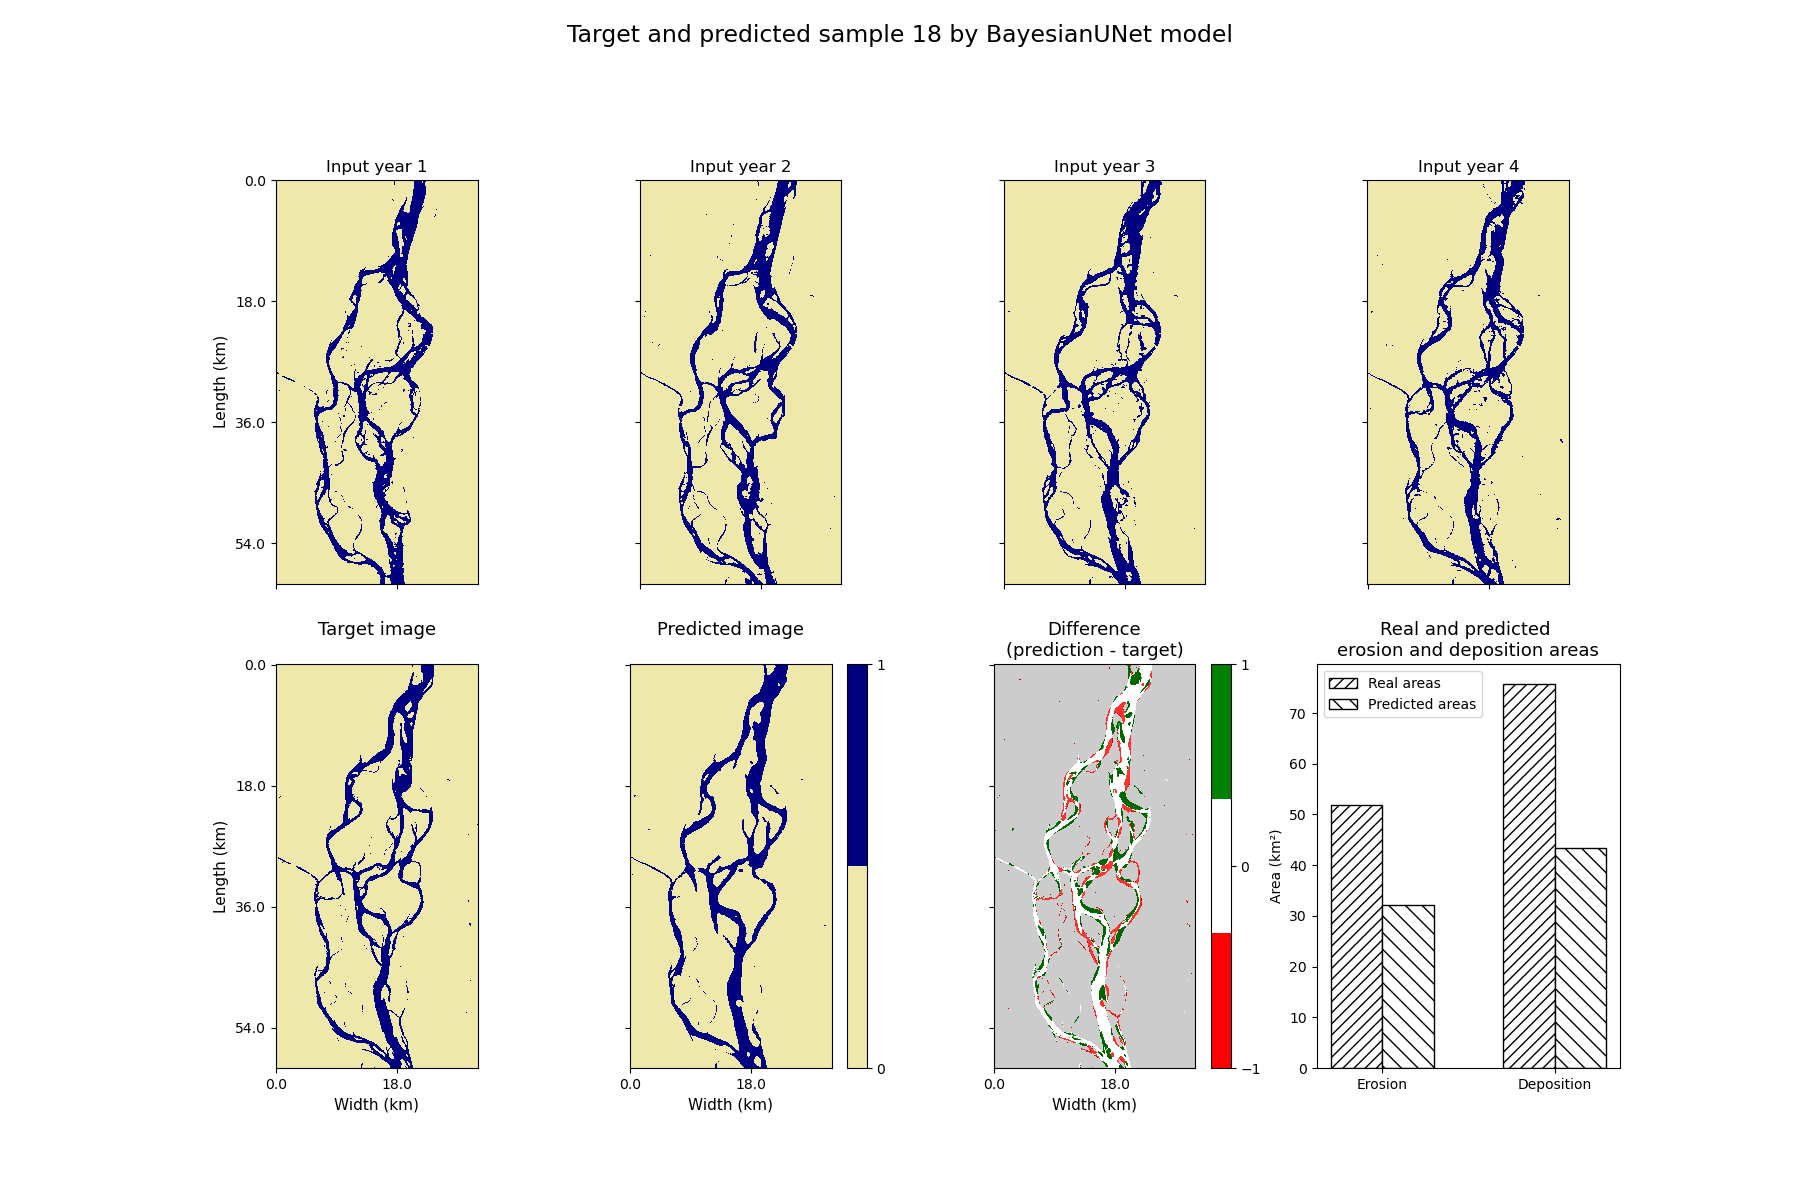

In [27]:
show_evolution(18, test_set, model_loss)

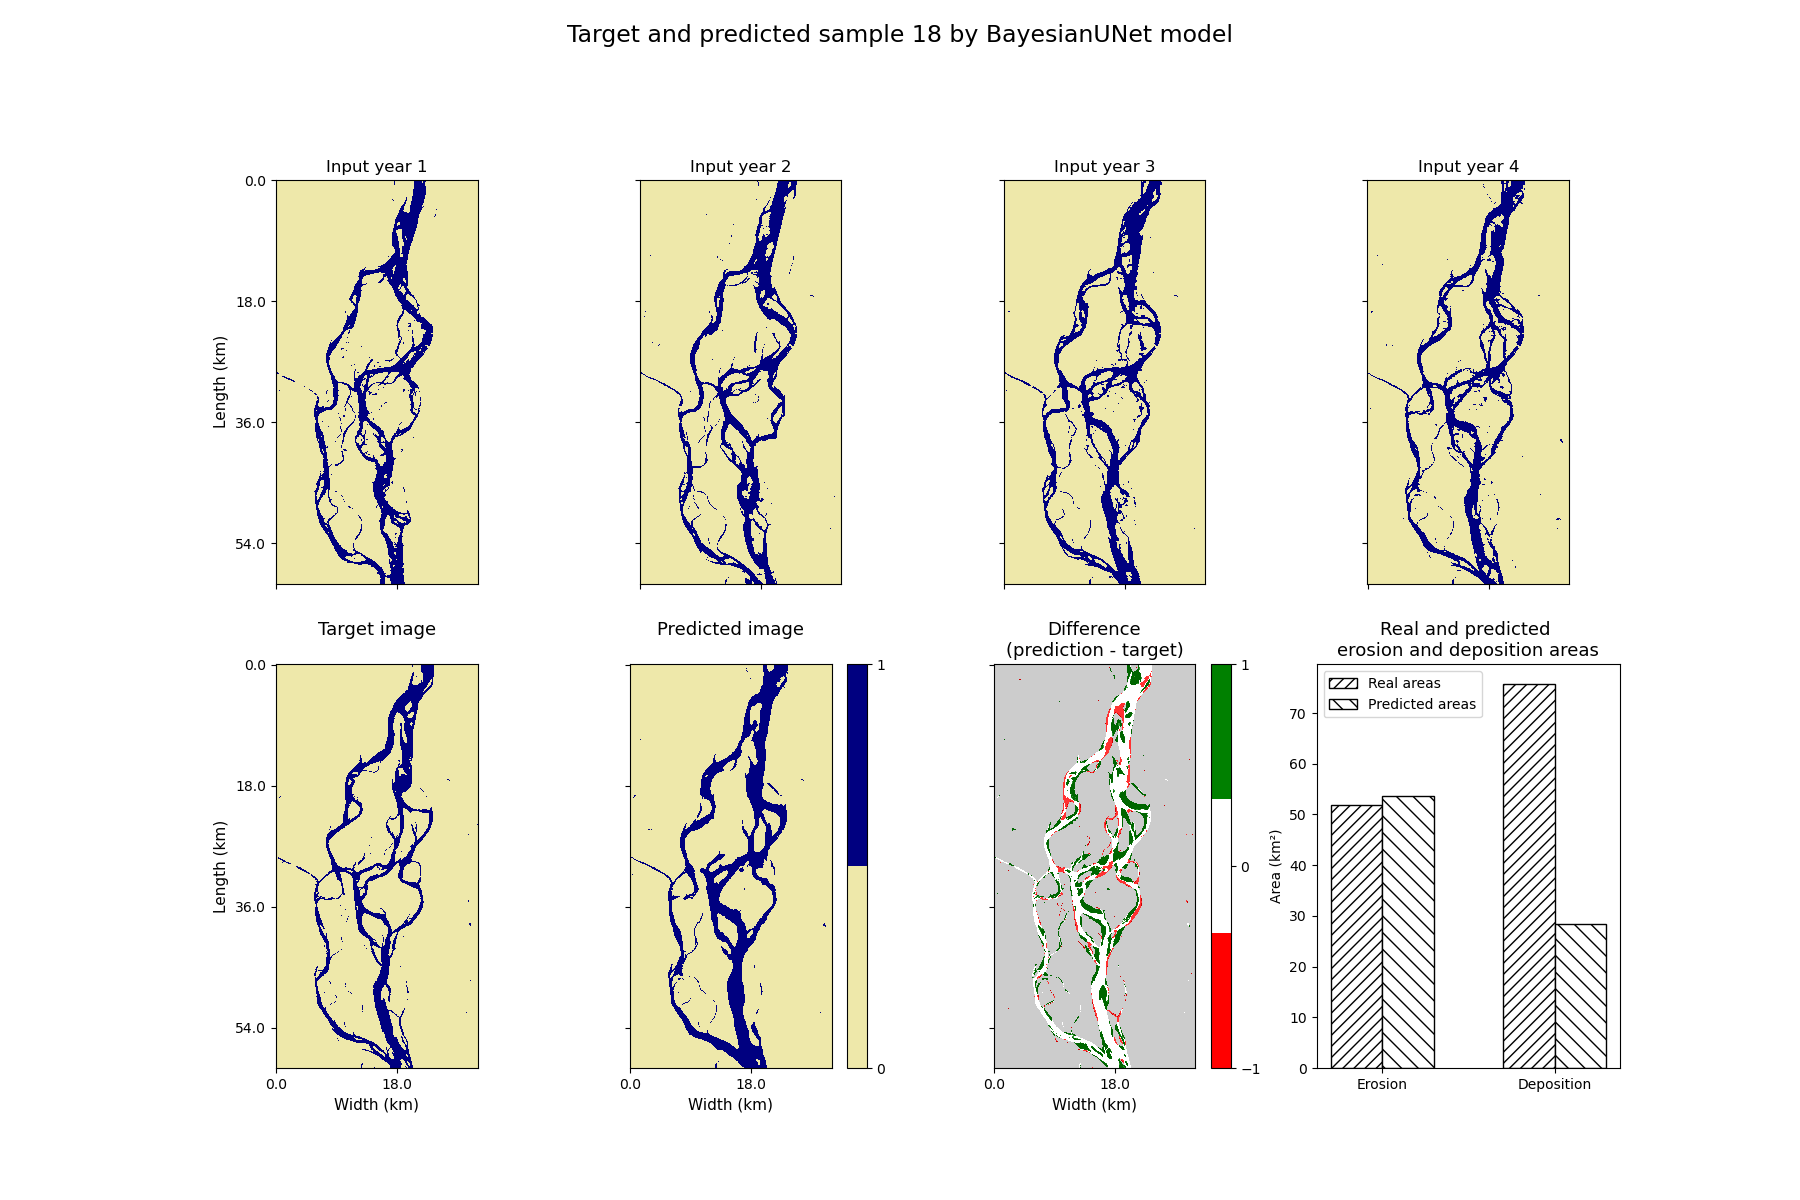

In [29]:
show_evolution(18, test_set, model_recall)

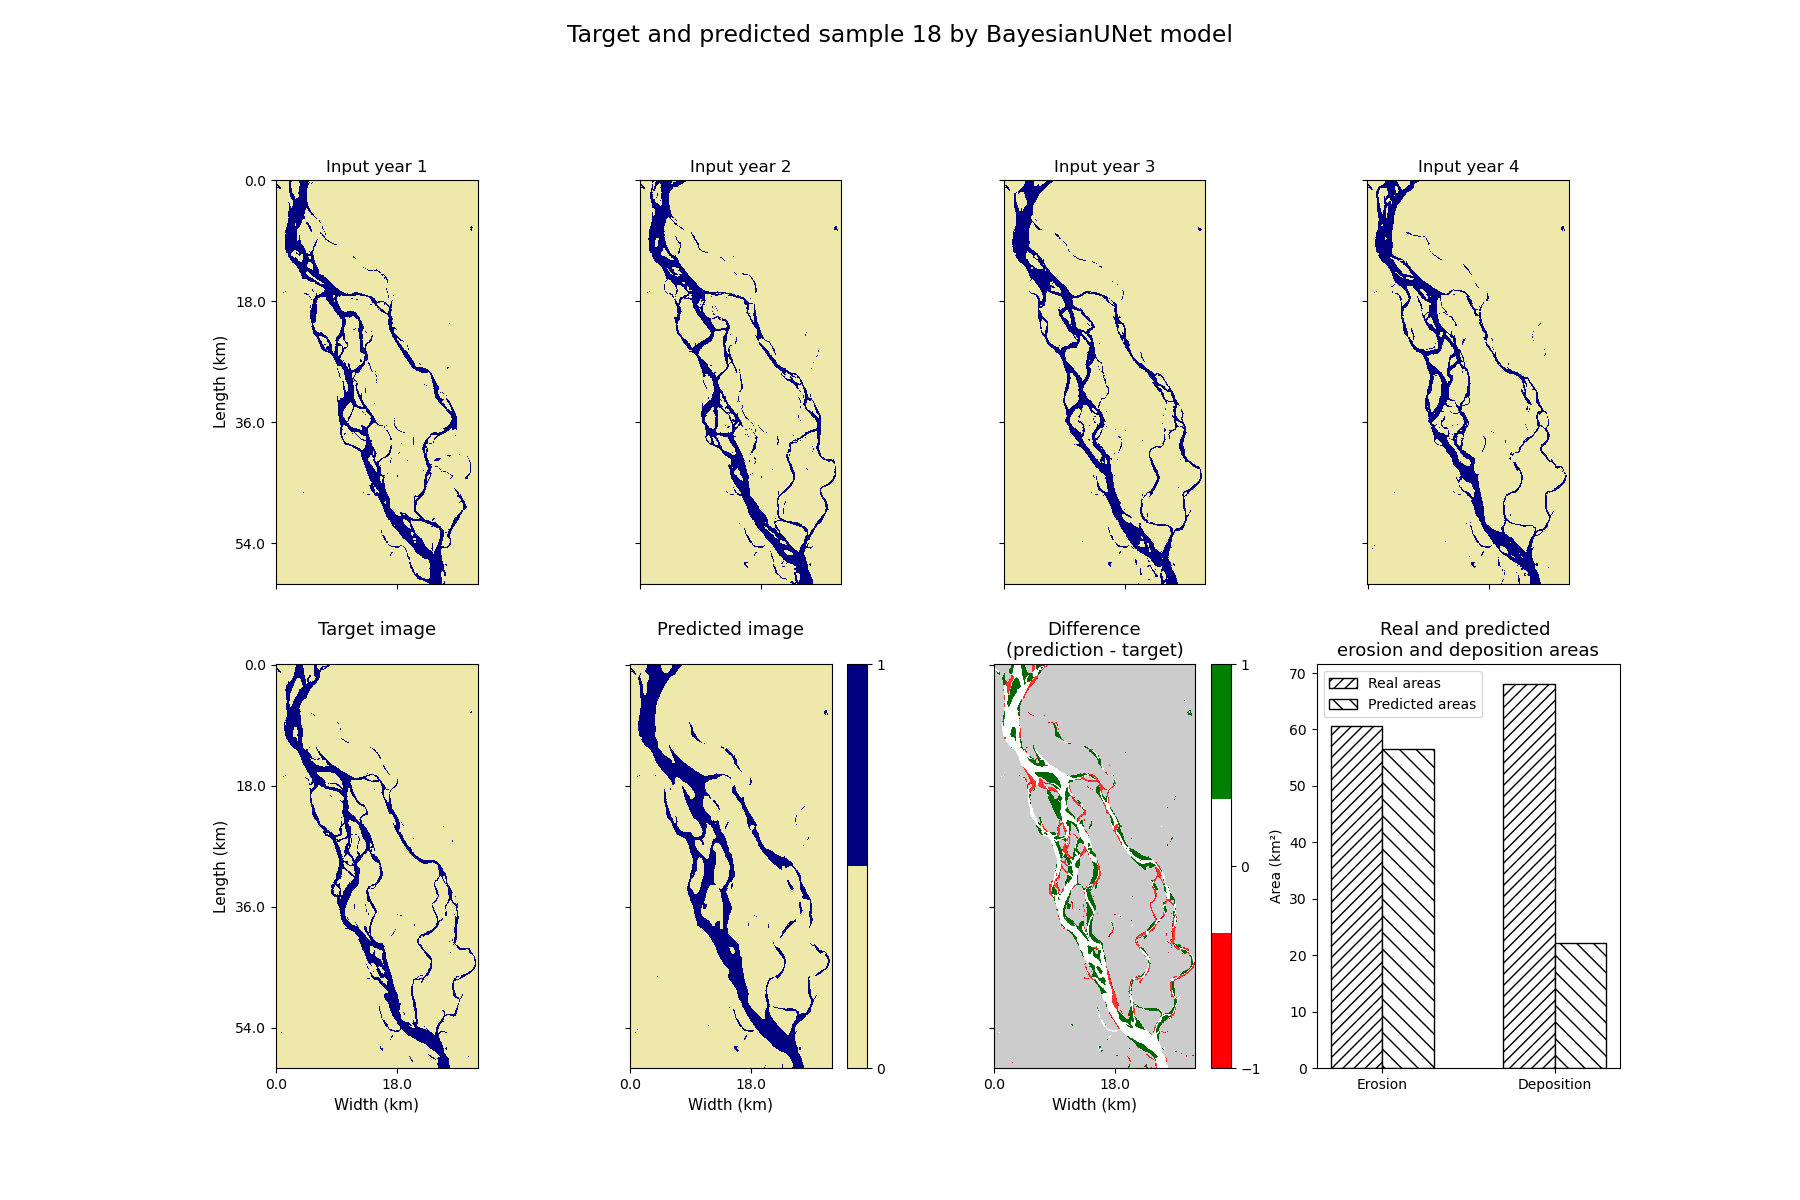

In [30]:
show_evolution(18, val_set, model_recall)

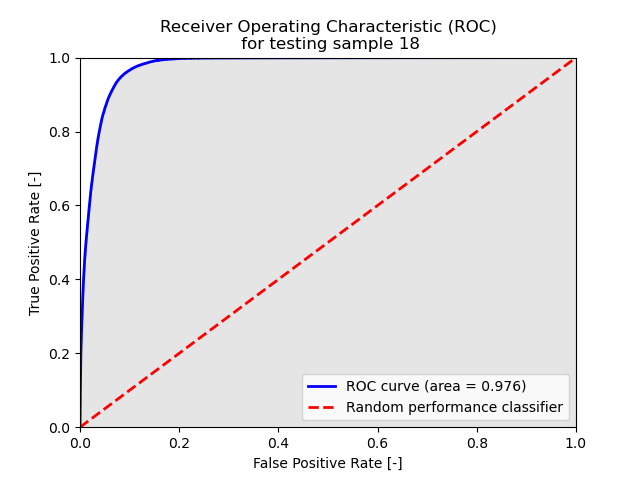

In [32]:
single_roc_curve(model_loss, test_set, sample=18, device=device);

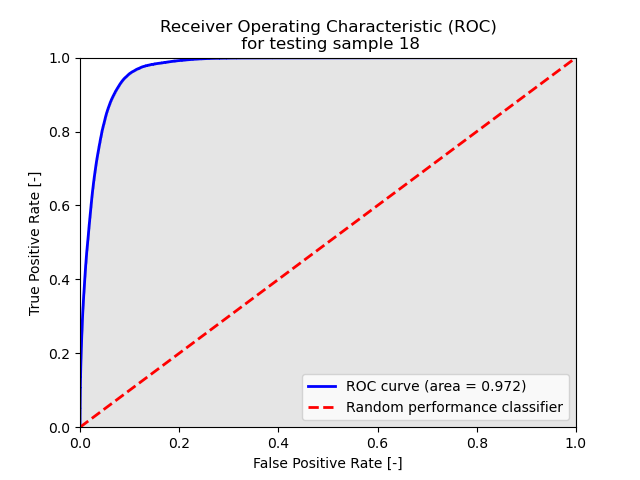

In [34]:
single_roc_curve(model_recall, test_set, sample=18, device=device);

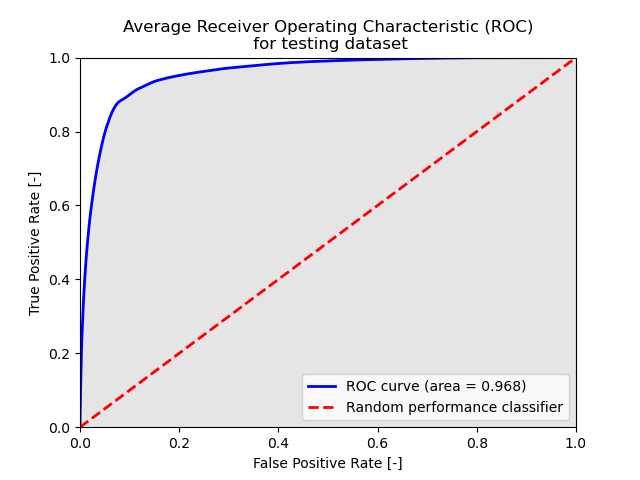

In [35]:
get_total_roc_curve(model_loss, test_set, device=device);

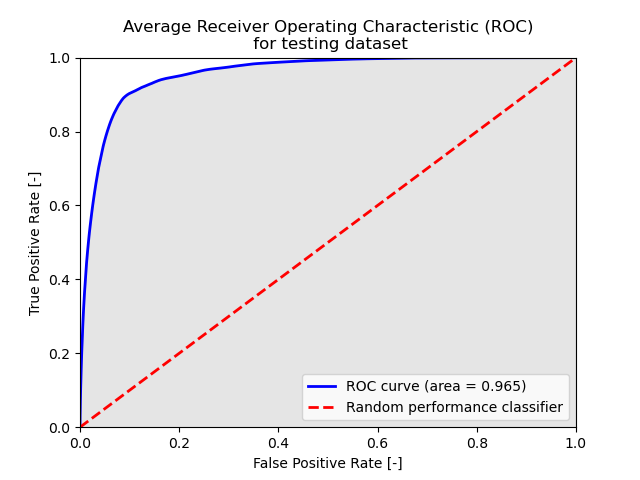

In [36]:
get_total_roc_curve(model_recall, test_set, device=device);

In [ ]:
single_pr_curve(model_loss, test_set, sample=19, device=device)

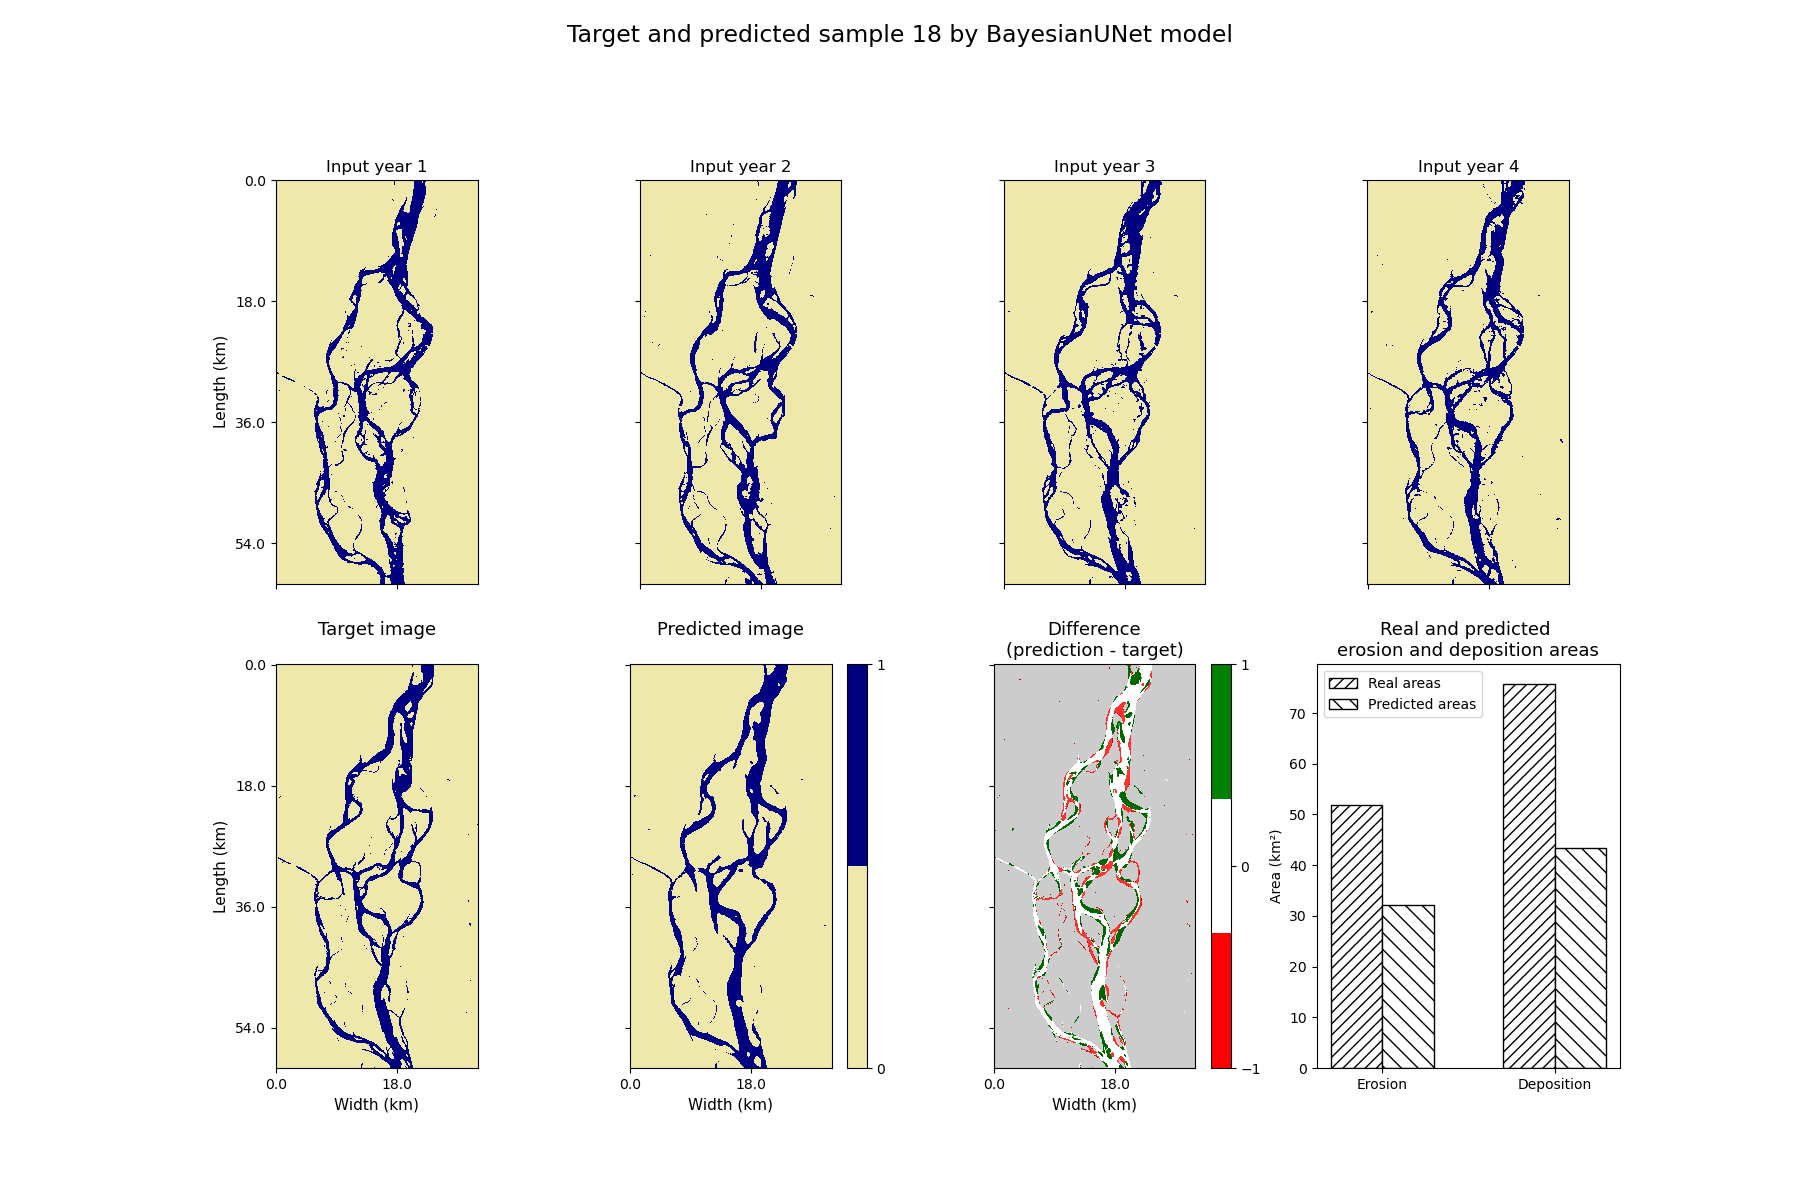

In [44]:
show_evolution(18, test_set, model_loss)